## **Importing Essential Libraries, Metrics, Tools and Models**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)

from imblearn.over_sampling import SMOTE
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel

In [ ]:
df = pd.read_csv("../datasets/water_potability.csv")

## **Exploratory Data Analysis, Statistical Interpretation and Visualizations**

### Taking a look at the first 5 rows of the dataset

In [3]:
df.head()

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0

In [4]:
df.shape

(3276, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [6]:
df.describe()

ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        16.175008     0.780382     0.487849  
min      181.483754        2.200000         0.738000     1.450000     0.000000  
25%      365.734414       12.065801        55.844536     3.439711     0.000000  
50%      421.884968       14.218338        66.622485     3.955028     0.000000  
75%      481.792304       16.557652        77.337473     4.500320     1.000000  
max      753.342620       28.300000       124.000000     6.739000     1.000000

### Handling Missing Values and Duplicates

**As we can see, there are missing values in columns "ph", "Sulfate" and "Trihalomethanes".**

In [7]:
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

**Visualizing the Nullity Matrix(missing values).**

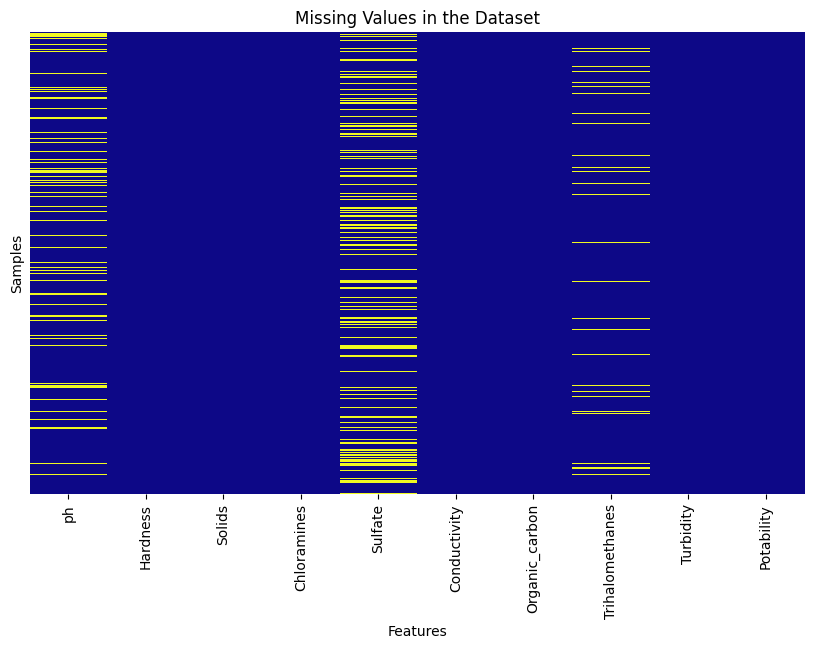

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap="plasma", cbar=False, yticklabels=False)
plt.xlabel("Features")
plt.ylabel("Samples")
plt.title("Missing Values in the Dataset")
plt.show()

The heatmap shows the presence of missing values in the dataset, with ph, Sulfate, and Trihalomethanes having missing values, while other features like Hardness, Solids, and Turbidity have no missing values.

---

### Why Impute Missing Values Based on "Potability"?

Imputing missing values based on the "Potability" column ensures that missing data is filled with values that are consistent with the group (Potability = 1 or Potability = 0). 

- **Contextual Imputation**: Potable and non-potable water might have different characteristics, so filling missing values with the average from the same group (Potability = 1 or 0) keeps the imputation relevant.
- **Preserving Group Characteristics**: This approach maintains the distinct characteristics of each group, ensuring more accurate imputations.
- **Avoiding Bias**: By imputing separately for each group, we prevent bias that might occur if we impute using the overall mean.


In [9]:
df['ph'] = df['ph'].fillna(df.groupby(['Potability'])['ph'].transform('mean'))
df['Sulfate'] = df['Sulfate'].fillna(df.groupby(['Potability'])['Sulfate'].transform('mean'))
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(df.groupby(['Potability'])['Trihalomethanes'].transform('mean'))

**It seems that there is no duplicate in the dataset.**

In [10]:
df.duplicated().sum()

np.int64(0)

### **Data Validation: Handling Extreme Values in Water Quality Measurements**

Validating and handling extreme values is essential for ensuring data quality, detecting measurement issues, and refining feature engineering.

#### **Types of Extreme Values**  

1. **Physically Impossible Values** – Violate natural laws or measurement constraints.  
2. **Physically Possible but Extreme Values** – Rare but plausible measurements.  
3. **Values Outside Normal Operating Ranges** – Theoretically valid but outside reliable analytical ranges.  


In [11]:
def identify_impossible_values(df):
    """
    Identifies physically impossible measurements in water quality data.
    """
    impossible_conditions = {
        'pH': (df['ph'] < 0) | (df['ph'] > 14),
        'Conductivity': df['Conductivity'] < 0,
        'Hardness': df['Hardness'] < 0
    }
    
    for feature, condition in impossible_conditions.items():
        impossible_count = condition.sum()
        if impossible_count > 0:
            print(f"{feature}: {impossible_count} impossible values found")
        else:
            print(f"{feature}: No imposible values found.")

identify_impossible_values(df)

pH: No imposible values found.
Conductivity: No imposible values found.
Hardness: No imposible values found.


### Data Distribution of each variable

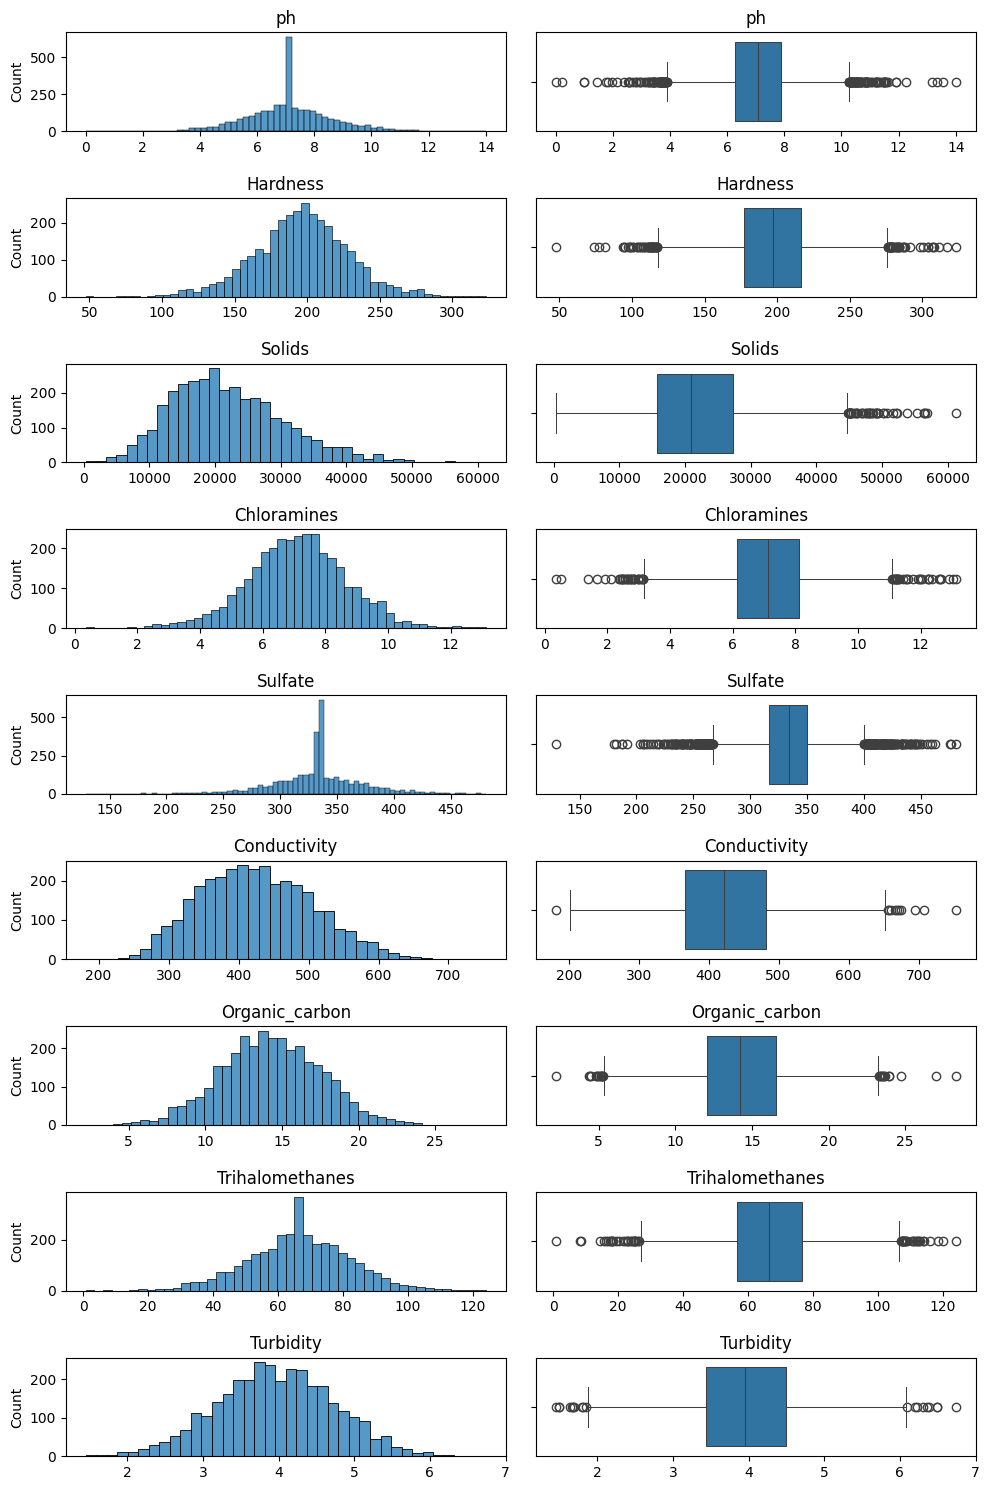

In [12]:
fig, axes = plt.subplots(9, 2, figsize=(10, 15))

for idx, col in enumerate(df.columns[:-1]):
    sns.histplot(data=df, x=col, ax=axes[idx,0],edgecolor='black')
    axes[idx,0].set_title(col)
    axes[idx,0].set_xlabel("")

    sns.boxplot(data=df, x=col, ax=axes[idx,1], orient='h', linewidth=.75)
    axes[idx,1].set_title(col)
    axes[idx,1].set_xlabel("")

plt.tight_layout(h_pad=1.5, w_pad=1.5)
plt.show()

The distribution looks quite symmetric for most of the features.

<h3> Outlier Detection and Removal </h3>

In [13]:
numerical_columns = df.select_dtypes(include=[np.number])

def remove_outliers_iqr(df, numerical_columns):
    """
    Removes outliers from the specified numerical columns of the DataFrame using the Interquartile Range (IQR) method.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    numerical_columns (list): A list of numerical column names to check for outliers.

    Returns:
    pandas.DataFrame: A DataFrame with outliers removed from the specified numerical columns.
    """
    Q1 = df[numerical_columns].quantile(0.25)
    Q3 = df[numerical_columns].quantile(0.75)
    IQR = Q3 - Q1
    df_no_outliers = df[~((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_no_outliers

df_no_outliers_iqr = remove_outliers_iqr(df, numerical_columns.columns)


**Scaling the data for visualization since all of them are on differenct scales.**

In [14]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numerical_columns.columns] = scaler.fit_transform(df[numerical_columns.columns])

In [15]:
df_no_outliers_iqr_scaled = df_no_outliers_iqr.copy()
df_no_outliers_iqr_scaled[numerical_columns.columns] = scaler.fit_transform(df_no_outliers_iqr[numerical_columns.columns])

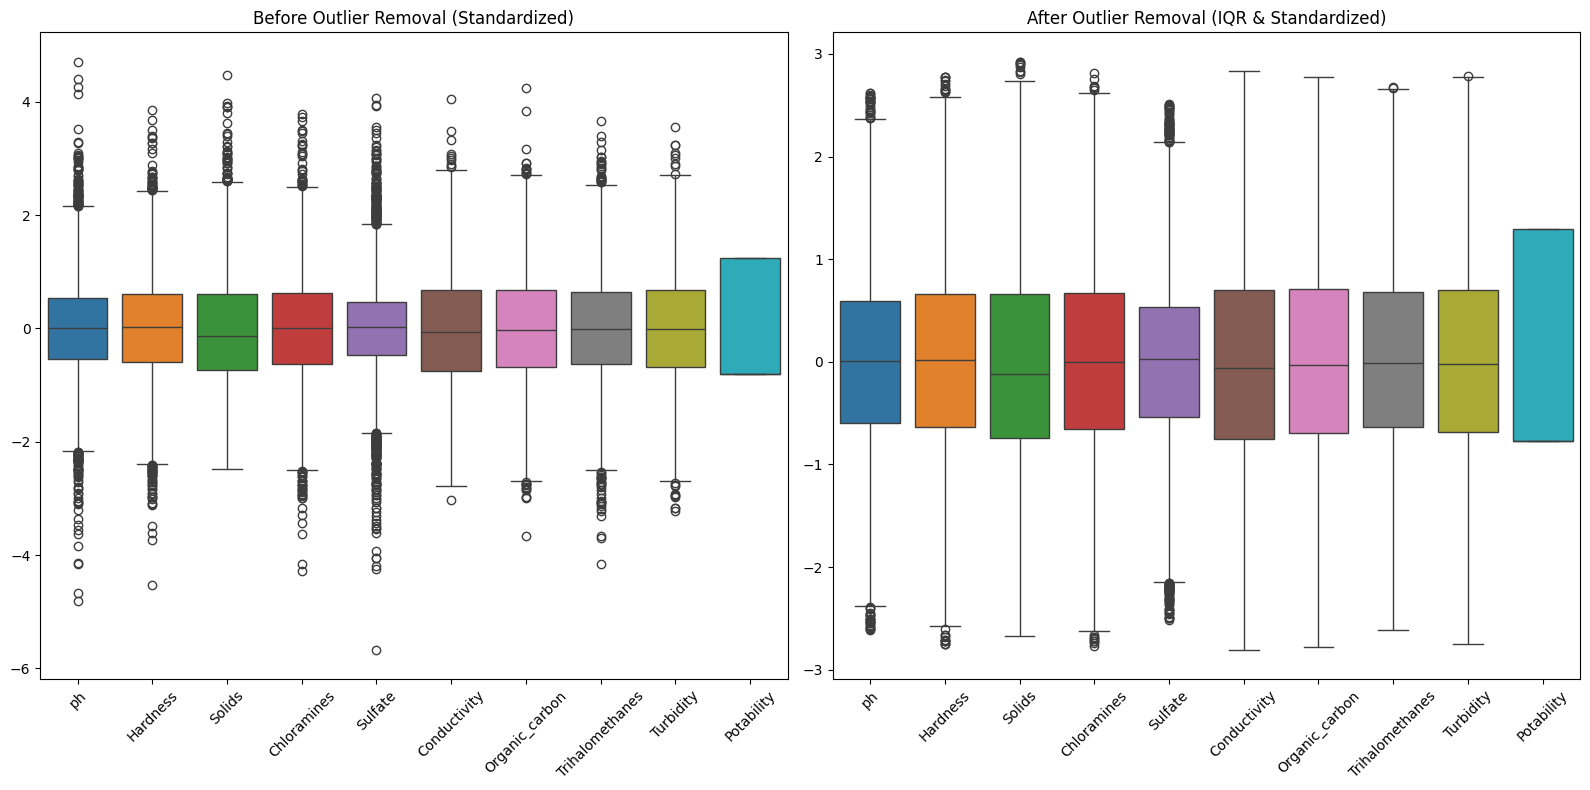

In [16]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_scaled[numerical_columns.columns])
plt.title("Before Outlier Removal (Standardized)")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_no_outliers_iqr_scaled[numerical_columns.columns])
plt.title("After Outlier Removal (IQR & Standardized)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [17]:
print(f"Original DataFrame shape: {df.shape}")
print(f"DataFrame shape after IQR-based outlier removal: {df_no_outliers_iqr.shape}")

Original DataFrame shape: (3276, 10)
DataFrame shape after IQR-based outlier removal: (2666, 10)


In [18]:
df = df_no_outliers_iqr

### Data Visualization

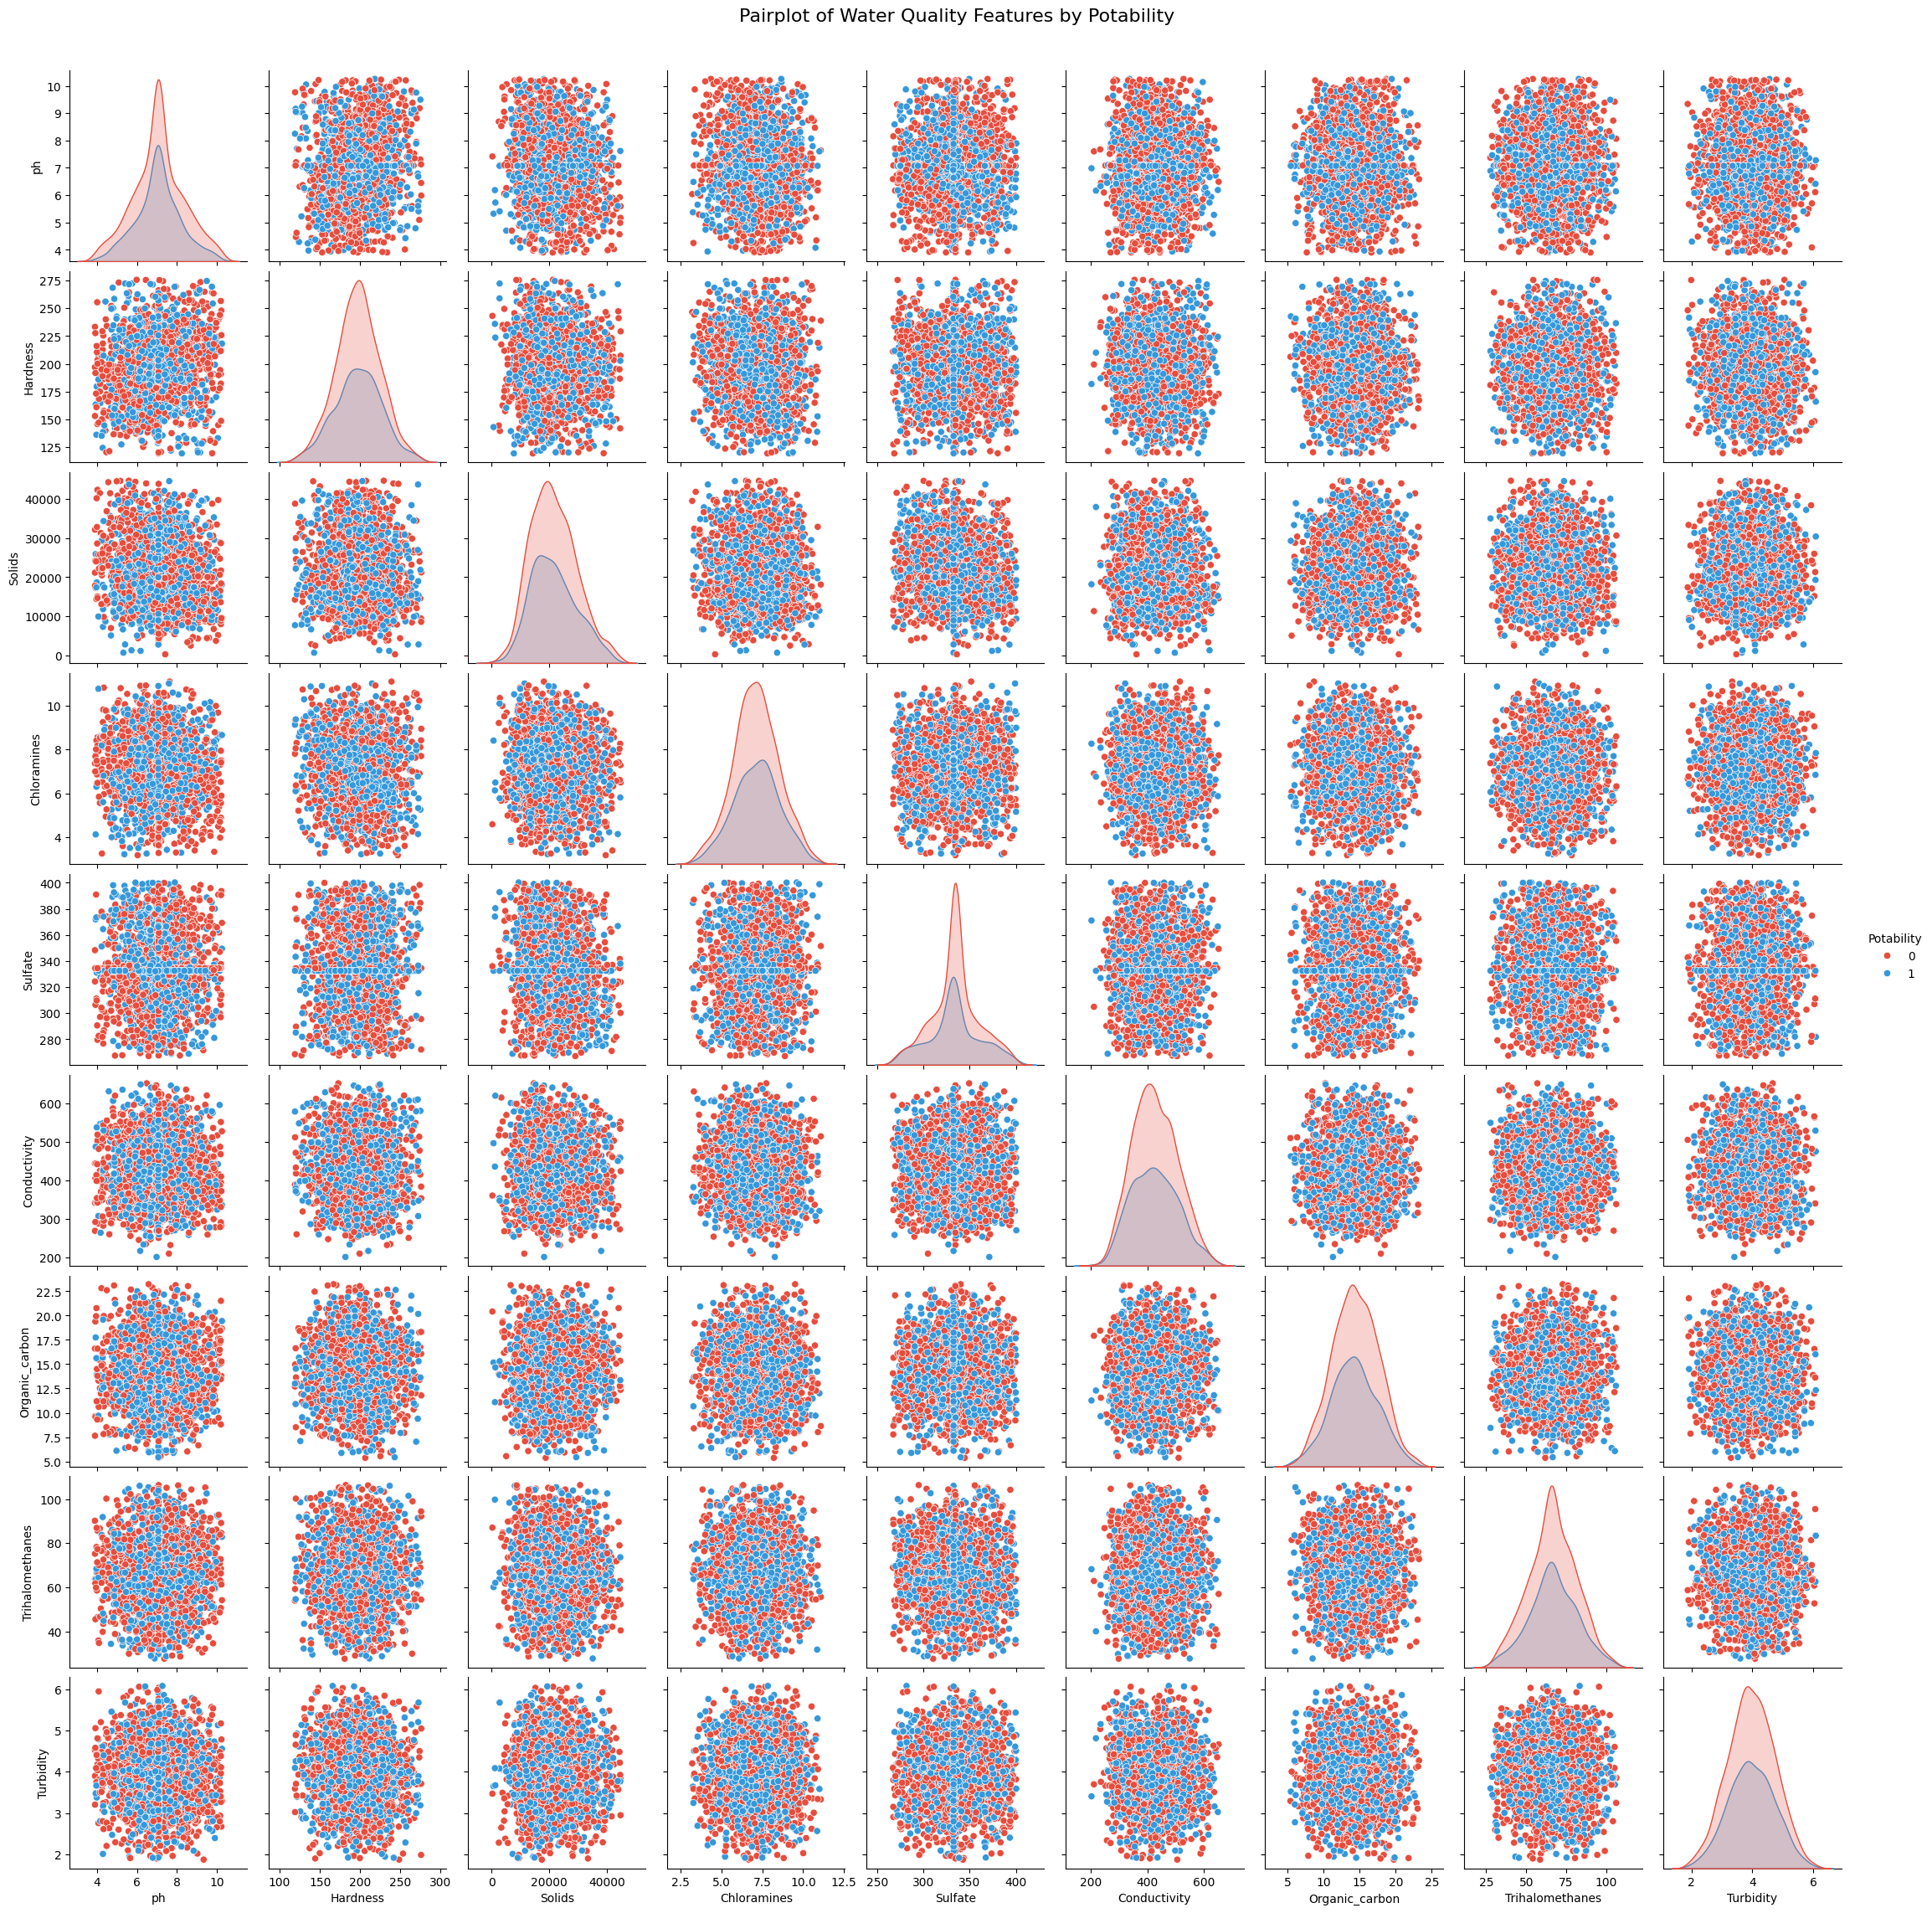

In [19]:
pairplot = sns.pairplot(df, hue="Potability", palette={0: "#e74c3c", 1: "#3498db"})
pairplot.fig.suptitle("Pairplot of Water Quality Features by Potability", fontsize=16, y=1.02)
plt.show()

**Pie chart to see value counts percentage of the target column**

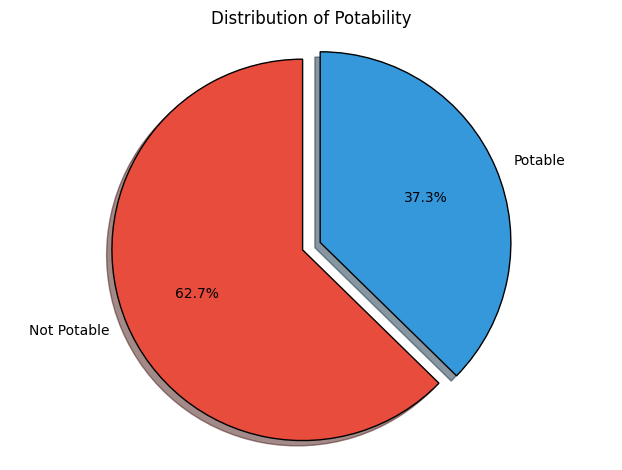

In [20]:
plt.pie(df['Potability'].value_counts(), 
        labels=["Not Potable", "Potable"], 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=["#e74c3c", "#3498db"], 
        explode=(0.1, 0), 
        shadow=True, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'linestyle': 'solid'}) 

plt.title("Distribution of Potability")
plt.axis('equal')
plt.tight_layout()
plt.show()

The target column is imbalanced with having 62.7% of the data as the Non Potable water rows.

**Visualizing the linear correlations between variables using Heatmap Visualization. The measure used for finding the linear correlation between each variable is Pearson Correlation Coefficient.**

Potability         1.000000
Trihalomethanes    0.014706
Chloramines        0.013195
Solids             0.005600
Turbidity          0.004761
Hardness          -0.000710
Conductivity      -0.001886
ph                -0.006631
Sulfate           -0.013112
Organic_carbon    -0.027090
Name: Potability, dtype: float64


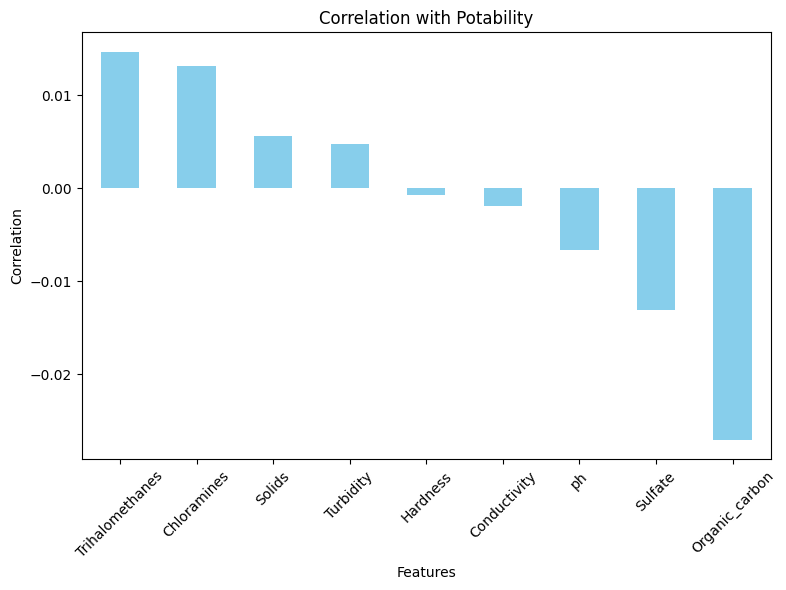

In [21]:
correlation = df.corr()['Potability'].sort_values(ascending=False)
print(correlation)
plt.figure(figsize=(8, 6))
correlation.drop('Potability').plot(kind='bar', color='skyblue')
plt.title('Correlation with Potability')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


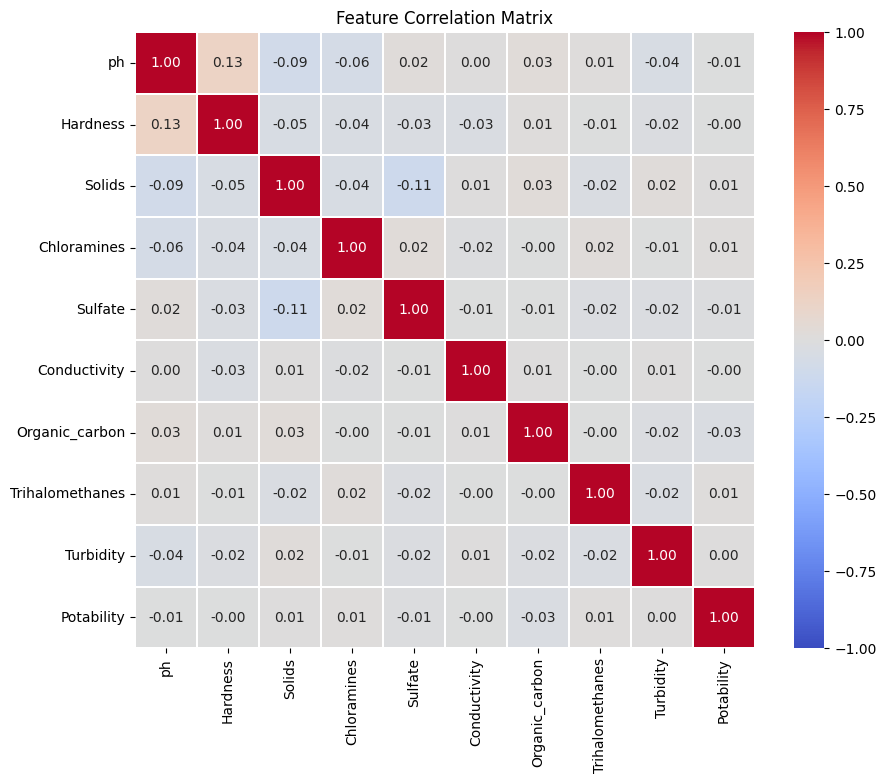

In [22]:
fig, axes = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", linecolor='white', linewidths=0.2, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

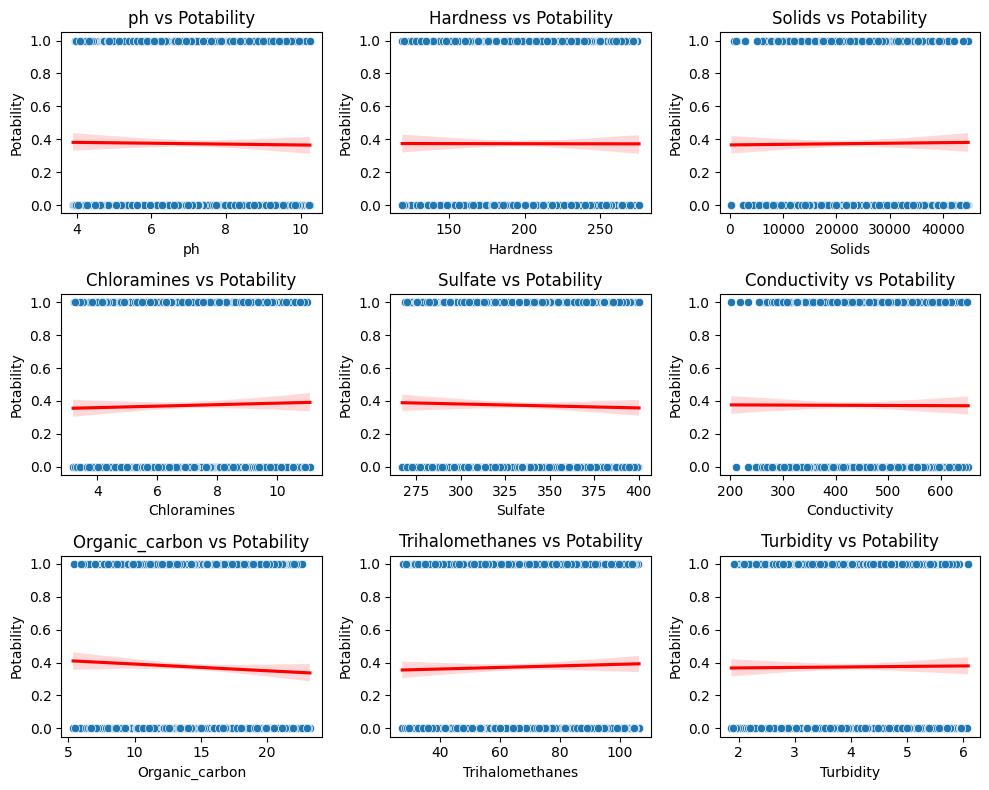

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(10, 8))
axes = axes.ravel()

for idx, column in enumerate(df.columns[:-1]):
    sns.scatterplot(data=df, x=column, y='Potability', ax=axes[idx])
    sns.regplot(data=df, x=column, y='Potability', ax=axes[idx], scatter=False, color='red')
    axes[idx].set_title(f'{column} vs Potability')

plt.tight_layout()
plt.show()

We can see **very weak** or **no clear relationship** in the features vs target

### X, y Split

In [24]:
X = df.drop("Potability", axis=1)
y = df["Potability"]

In [25]:
print("Original X shape:", X.shape)
print("Original y shape:", y.shape)

Original X shape: (2666, 9)
Original y shape: (2666,)


<h3>Train Test Split</h3>

**Split into train val and test**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42,stratify=y_test)

In [27]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1866, 9)
y_train shape: (1866,)
X_val shape: (400, 9)
y_val shape: (400,)
X_test shape: (400, 9)
y_test shape: (400,)


**Fixing the Class Imbalance**

Since undersampling could result in information loss --> **underfitting** , oversampling by duplicating the minority samples could lead to **overfitting**.

So generating synthetic samples form the original ones using SMOTE sounded good.

In [28]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [29]:
print("X_train_resampled shape:", X_train_resampled.shape)
print("y_train_resampled shape:", y_train_resampled.shape)

X_train_resampled shape: (2340, 9)
y_train_resampled shape: (2340,)


<h3>Data Scaling</h3>

Scaling the data for sable gradient updates

In [30]:
scaler = StandardScaler()
print("Before Scaling:", X_train_resampled.shape)
X_train_scaled = scaler.fit_transform(X_train_resampled)
print("After Scaling:", X_train_scaled.shape)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Before Scaling: (2340, 9)
After Scaling: (2340, 9)


In [31]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train_resampled.shape)

X_train_scaled shape: (2340, 9)
y_train shape: (2340,)


In [32]:
y_train = y_train_resampled

## **Logistic Regression Model from Scratch**

In [33]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

class LogisticRegression:
    """
    A simple implementation of Logistic Regression with gradient descent optimization.
    Supports L2 regularization and validation set tracking.
    """
    
    def __init__(self, learning_rate=0.001, n_iterations=2000, regularization=0.0, random_state=42):
        """
        Initializes the Logistic Regression model.
        
        Parameters:
        learning_rate (float): The step size for gradient descent.
        n_iterations (int): Number of iterations for training.
        regularization (float): L2 regularization strength (lambda).
        random_state (int): Random seed for weight initialization.
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.train_losses = []
        self.val_losses = []
        self.X_val = None
        self.y_val = None

    def initialize_weights(self, n_features):
        """
        Initializes model weights and bias.
        
        Parameters:
        n_features (int): Number of features in the dataset.
        """
        np.random.seed(self.random_state)
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0

    def sigmoid(self, z):
        """
        Computes the sigmoid activation function.
        
        Parameters:
        z (numpy.ndarray): Input array.
        
        Returns:
        numpy.ndarray: Sigmoid output.
        """
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, y, y_pred):
        """
        Computes the binary cross-entropy loss with L2 regularization.
        
        Parameters:
        y (numpy.ndarray): True labels.
        y_pred (numpy.ndarray): Predicted probabilities.
        
        Returns:
        float: Computed loss value.
        """
        m = len(y)
        loss = - (1 / m) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        reg_term = (self.regularization / (2 * m)) * np.sum(np.square(self.weights))
        return loss + reg_term

    def compute_gradients(self, X, y, y_pred):
        """
        Computes gradients for weight and bias updates.
        
        Parameters:
        X (numpy.ndarray): Feature matrix.
        y (numpy.ndarray): True labels.
        y_pred (numpy.ndarray): Predicted probabilities.
        
        Returns:
        tuple: Gradients for weights (dw) and bias (db).
        """
        m = len(y)
        dw = (1 / m) * np.dot(X.T, (y_pred - y)) + (self.regularization / m) * self.weights
        db = (1 / m) * np.sum(y_pred - y)
        return dw, db

    def fit_val(self, X_val, y_val):
        """
        Stores validation data for tracking performance.
        
        Parameters:
        X_val (numpy.ndarray): Validation feature matrix.
        y_val (numpy.ndarray): Validation labels.
        """
        self.X_val = np.array(X_val)
        self.y_val = np.array(y_val).ravel()

    def fit(self, X, y, verbose=True):
        """
        Trains the logistic regression model using gradient descent.
        
        Parameters:
        X (numpy.ndarray): Training feature matrix.
        y (numpy.ndarray): Training labels.
        verbose (bool): If True, prints training progress every 100 iterations.
        """
        X = np.array(X)
        y = np.array(y).ravel()
        m, n_features = X.shape
        self.initialize_weights(n_features)

        for i in range(self.n_iterations):
            y_pred = self.sigmoid(np.dot(X, self.weights) + self.bias)
            dw, db = self.compute_gradients(X, y, y_pred)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            if verbose and i % 100 == 0:
                train_loss = self.compute_loss(y, y_pred)
                self.train_losses.append(train_loss)
                print(f"Epoch {i}: Train Loss = {train_loss:.4f}")

                if self.X_val is not None and self.y_val is not None:
                    val_pred = self.sigmoid(np.dot(self.X_val, self.weights) + self.bias)
                    val_loss = self.compute_loss(self.y_val, val_pred)
                    self.val_losses.append(val_loss)
                    val_pred_class = (val_pred >= 0.5).astype(int)
                    accuracy = accuracy_score(self.y_val, val_pred_class)
                    f1 = f1_score(self.y_val, val_pred_class)
                    print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {accuracy:.4f}, Validation F1 Score = {f1:.4f}")

    def predict_proba(self, X):
        """
        Predicts probabilities for given input data.
        
        Parameters:
        X (numpy.ndarray): Input feature matrix.
        
        Returns:
        numpy.ndarray: Predicted probabilities.
        """
        return self.sigmoid(np.dot(X, self.weights) + self.bias)

    def predict(self, X, threshold=0.5):
        """
        Predicts binary labels for given input data.
        
        Parameters:
        X (numpy.ndarray): Input feature matrix.
        threshold (float): Decision threshold for classification.
        
        Returns:
        numpy.ndarray: Predicted binary labels (0 or 1).
        """
        return (self.predict_proba(X) >= threshold).astype(int)

In [34]:
epochs=2500
lr=LogisticRegression(n_iterations=epochs)
lr.fit_val(X_val_scaled,y_val)
lr.fit(X_train_scaled,y_train)

Epoch 0: Train Loss = 0.6934
Validation Loss = 0.6932, Validation Accuracy = 0.5000, Validation F1 Score = 0.4083
Epoch 100: Train Loss = 0.6933
Validation Loss = 0.6932, Validation Accuracy = 0.4950, Validation F1 Score = 0.4229
Epoch 200: Train Loss = 0.6931
Validation Loss = 0.6931, Validation Accuracy = 0.5025, Validation F1 Score = 0.4298
Epoch 300: Train Loss = 0.6930
Validation Loss = 0.6930, Validation Accuracy = 0.5175, Validation F1 Score = 0.4373
Epoch 400: Train Loss = 0.6929
Validation Loss = 0.6929, Validation Accuracy = 0.5200, Validation F1 Score = 0.4419
Epoch 500: Train Loss = 0.6928
Validation Loss = 0.6929, Validation Accuracy = 0.5050, Validation F1 Score = 0.4310
Epoch 600: Train Loss = 0.6926
Validation Loss = 0.6928, Validation Accuracy = 0.5150, Validation F1 Score = 0.4393
Epoch 700: Train Loss = 0.6925
Validation Loss = 0.6928, Validation Accuracy = 0.5000, Validation F1 Score = 0.4220
Epoch 800: Train Loss = 0.6924
Validation Loss = 0.6927, Validation Accura

**Epochs vs Train and Validation Loss**

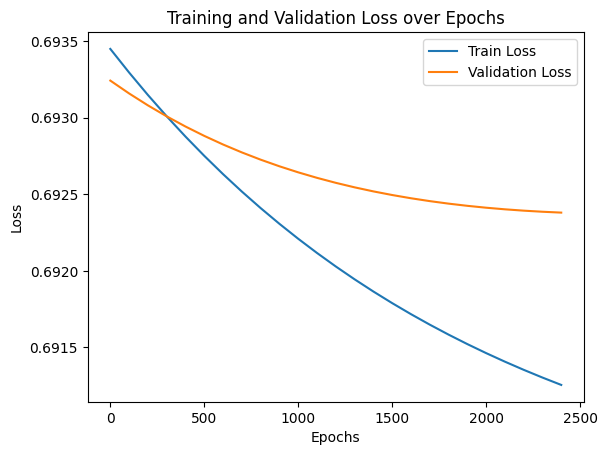

In [35]:
epochs_logged = range(0, epochs, 100)
plt.plot(epochs_logged, lr.train_losses, label="Train Loss")
plt.plot(epochs_logged, lr.val_losses, label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

In [36]:
train_pred = lr.predict(X_train_scaled)
test_pred = lr.predict(X_test_scaled)

In [37]:
train_accuracy = round(accuracy_score(y_train, train_pred), 2)
train_precision = round(precision_score(y_train, train_pred), 2)
train_recall = round(recall_score(y_train, train_pred), 2)
train_f1 = round(f1_score(y_train, train_pred), 2)

print("Training Accuracy:", train_accuracy)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1)


Training Accuracy: 0.53
Training Precision: 0.53
Training Recall: 0.52
Training F1 Score: 0.52


In [38]:
test_accuracy = round(accuracy_score(y_test, test_pred), 2)
test_precision = round(precision_score(y_test, test_pred), 2)
test_recall = round(recall_score(y_test, test_pred), 2)
test_f1 = round(f1_score(y_test, test_pred), 2)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

Test Accuracy: 0.49
Test Precision: 0.37
Test Recall: 0.51
Test F1 Score: 0.43


<span style="color:white">
The model is <span style="color:red"><b>underfitted</b></span> since it performs very bad on both the <span style="color:red"><b>train</b></span> and <span style="color:red"><b>test</b></span> sets. The dataset seems to have no visible <span style="color:red"><b>linear relationship</b></span>, due to which our custom <span style="color:red"><b>logistic regression</b></span> from scratch couldn't catch the pattern.
</span>


### Confusion Matrix

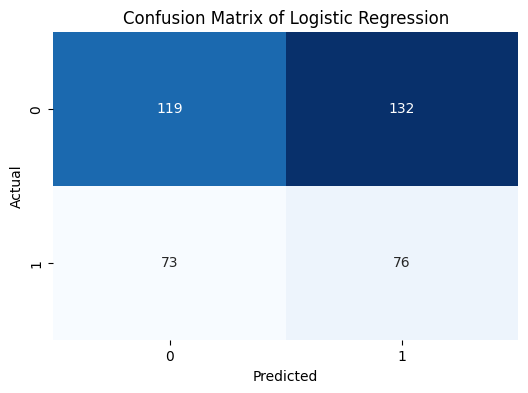

In [39]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, test_pred), annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix of Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## **Building two models (Random Forest, Gradient Boosting) from Sklearn**

In [40]:
initial_models = pd.DataFrame(columns=["Model", "Train Accuracy", "Test Accuracy", "Test F1 Score", "Test Precision", "Test Recall"])

In [41]:
initial_models_list = [("Random Forest", RandomForestClassifier(random_state=42)),
                       ("Gradient Boosting", GradientBoostingClassifier(random_state=42))]

In [42]:
for name, clf in initial_models_list:
    clf.fit(X_train_scaled, y_train)
    train_predictions = clf.predict(X_train_scaled)
    test_predictions = clf.predict(X_test_scaled)
    train_accuracy = round(accuracy_score(y_train, train_predictions), 2)
    test_accuracy = round(accuracy_score(y_test, test_predictions), 2)
    f1 = round(f1_score(y_test, test_predictions), 2)
    precision = round(precision_score(y_test, test_predictions), 2)
    recall = round(recall_score(y_test, test_predictions), 2)
    
    new_row = pd.DataFrame({"Model": [name], 
                            "Train Accuracy": [train_accuracy], 
                            "Test Accuracy": [test_accuracy], 
                            "Test F1 Score": [f1], 
                            "Test Precision": [precision], 
                            "Test Recall": [recall]})
    
    initial_models = pd.concat([initial_models, new_row], ignore_index=True)
    
    if name == "Random Forest":
        rf_clf = clf
        rf_train_predictions = train_predictions
        rf_test_predictions = test_predictions
    elif name == "Gradient Boosting":
        gb_clf = clf
        gb_train_predictions = train_predictions
        gb_test_predictions = test_predictions

In [43]:
initial_models = initial_models.sort_values(by="Test Accuracy", ascending=False)
initial_models

Model  Train Accuracy  Test Accuracy  Test F1 Score  \
0      Random Forest            1.00           0.72           0.65   
1  Gradient Boosting            0.87           0.71           0.67   

   Test Precision  Test Recall  
0            0.62         0.68  
1            0.58         0.79

### Visualization of Models vs Train and Test accuracy

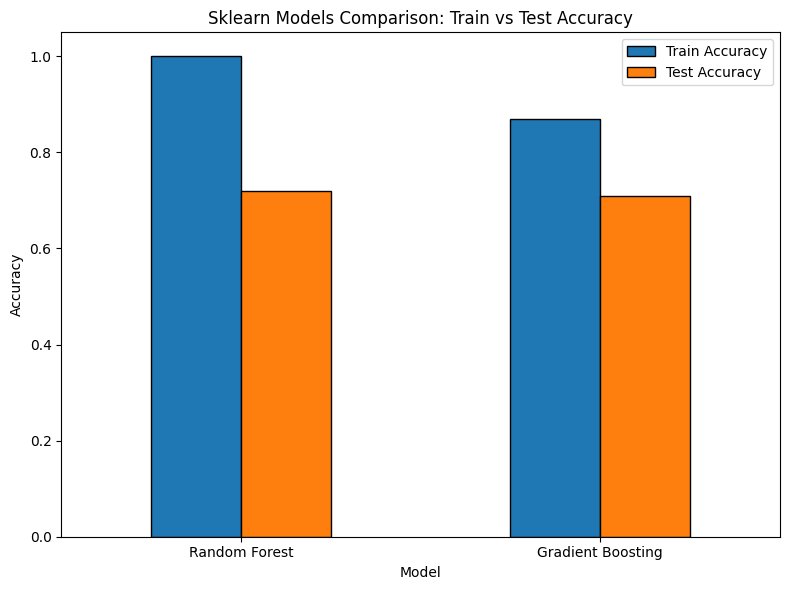

In [44]:
ax = initial_models.set_index('Model')[["Train Accuracy", "Test Accuracy"]].plot(kind="bar", figsize=(8, 6), edgecolor='black')

ax.set_xticklabels(initial_models["Model"], rotation=0)

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Sklearn Models Comparison: Train vs Test Accuracy')

plt.tight_layout()
plt.show()


### Confusion Matrix of Random Forest and Gradient Boosting models

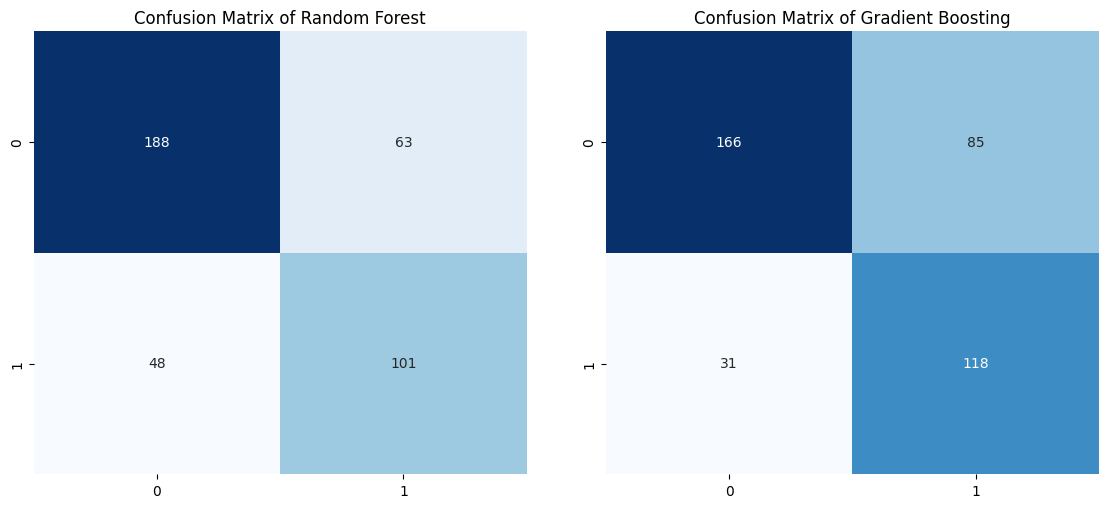

In [45]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, rf_test_predictions), annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix of Random Forest")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, gb_test_predictions), annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix of Gradient Boosting")

plt.tight_layout(pad=4.0)
plt.show()

<span style="color:white">
As of now, <span style="color:red"><b>Gradient Boosting</b></span> performed better since it has less difference between its <span style="color:red"><b>training metrics</b></span> and <span style="color:red"><b>test metrics</b></span>. While <span style="color:red"><b>test</b></span> being the same for both, the <span style="color:red"><b>GB</b></span> has less difference than <span style="color:red"><b>RF</b></span> does.

<span style="color:white"><b>Why I chose these models ?</b></span>

1. <span style="color:red"><b>Random Forest</b></span> and <span style="color:red"><b>Gradient Boosting</b></span> are both <span style="color:red"><b>ensemble models</b></span> that can handle complex datasets well. 
2. Both models are capable of capturing <span style="color:red"><b>non-linear relationships</b></span>, which is important since the features and target don't show strong linear correlations.
3. These models are <span style="color:red"><b>robust</b></span> and can perform well on different types of data, making them suitable for this task.
</span>


## **Hyperparameter Tuning**

### Tuning the Gradient Boosting Classifier

In [46]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 20 , 5,10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_clf = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=gb_clf,
                           param_grid=param_grid, 
                           cv=3,
                           n_jobs=-1,
                           verbose=0,
                           scoring='f1'
                           )

grid_search.fit(X_train_scaled, y_train)

gb_params = grid_search.best_params_

print("Best Hyperparameters:", gb_params)

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


### Tuning the Random Forest

In [47]:
param_grid_rfc = {
    "min_samples_split": [20, 30, 40],  
    "min_samples_leaf": [10, 15, 20],  
    "max_depth": [None , 10, 20, 30],   
    "n_estimators": [100, 150],        
    "max_features": ['sqrt', 'log2'],  
    "random_state": [42],
    "bootstrap": [True],              
}

grid_rfc = GridSearchCV(
    RandomForestClassifier(),
    param_grid_rfc,
    scoring="f1",
    cv=5,
    verbose=0,
    n_jobs=-1
)

grid_rfc.fit(X_train_scaled, y_train)

rfc_params = grid_rfc.best_params_

print("Best Hyperparameters:", rfc_params)

Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 150, 'random_state': 42}


### Best Hyperparameters for Models

- Gradient Boosting:
  - `learning_rate`: 0.1
  - `max_depth`: 5
  - `min_samples_leaf`: 2
  - `min_samples_split`: 5
  - `n_estimators`: 200

- Random Forest:
  - `bootstrap`: True
  - `max_depth`: 15
  - `max_features`: 'sqrt'
  - `min_samples_leaf`: 10
  - `min_samples_split`: 20
  - `n_estimators`: 150
  - `random_state`: 42

## **Feature Selection**

In [48]:
features = [
    "ph", "Hardness", "Solids", "Chloramines", "Sulfate", 
    "Conductivity", "Organic_carbon", "Trihalomethanes", "Turbidity"
]

### Random Forest Feature Selection

In [49]:
rf_model = RandomForestClassifier(**rfc_params)
rf_model.fit(X_train_scaled, y_train)

rf_selector = SelectFromModel(rf_model, max_features=7, threshold=-np.inf, prefit=True)

X_train_rf_selected = rf_selector.transform(X_train_scaled)
X_test_rf_selected = rf_selector.transform(X_test_scaled)
X_val_rf_selected = rf_selector.transform(X_val_scaled)

rf_selected_features = np.array(features)[rf_selector.get_support()]
print("Random Forest Selected Features:", rf_selected_features.tolist())

Random Forest Selected Features: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Organic_carbon', 'Turbidity']


### Gradient Boosting Feature Selection

In [50]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

gb_selector = SelectFromModel(gb_model,max_features=7 ,threshold=-np.inf ,prefit=True)

X_train_gb_selected = gb_selector.transform(X_train_scaled)
X_test_gb_selected = gb_selector.transform(X_test_scaled)
X_val_gb_selected = gb_selector.transform(X_val_scaled)

gb_selected_features = np.array(features)[gb_selector.get_support()]
print("Gradient Boosting Selected Features:", gb_selected_features.tolist())

Gradient Boosting Selected Features: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Trihalomethanes', 'Turbidity']


<h3> Most Contributing features </h3>

In [51]:
selected_features_df = pd.DataFrame({
    "Random Forest": rf_selected_features,
    "Gradient Boosting": gb_selected_features
})

selected_features_df.columns.name = "Feature Names"
selected_features_df

Feature Names   Random Forest Gradient Boosting
0                          ph                ph
1                    Hardness          Hardness
2                      Solids            Solids
3                 Chloramines       Chloramines
4                     Sulfate           Sulfate
5              Organic_carbon   Trihalomethanes
6                   Turbidity         Turbidity

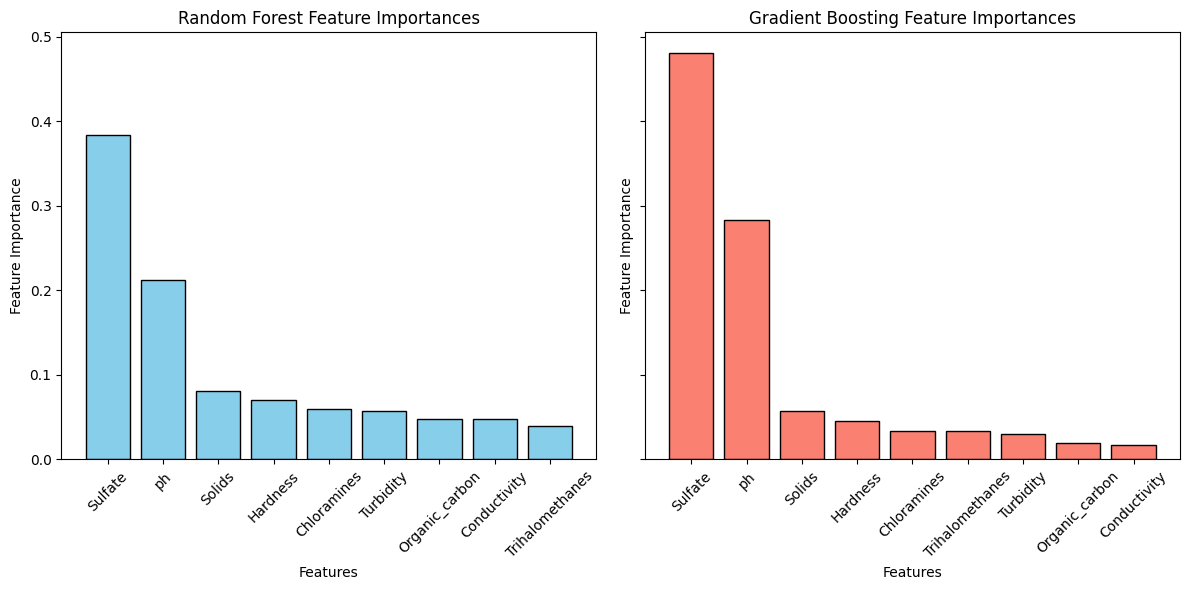

In [52]:
rf_importances = rf_model.feature_importances_
gb_importances = gb_model.feature_importances_

rf_feature_importance = {feature: importance for feature, importance in zip(features, rf_importances)}
gb_feature_importance = {feature: importance for feature, importance in zip(features, gb_importances)}

rf_sorted = sorted(rf_feature_importance.items(), key=lambda x: x[1], reverse=True)
gb_sorted = sorted(gb_feature_importance.items(), key=lambda x: x[1], reverse=True)

rf_features, rf_importances = zip(*rf_sorted)
gb_features, gb_importances = zip(*gb_sorted)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].bar(rf_features, rf_importances, color='skyblue', edgecolor='black')
axes[0].set_title('Random Forest Feature Importances')
axes[0].set_ylabel('Feature Importance')
axes[0].set_xlabel('Features')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(gb_features, gb_importances, color='salmon', edgecolor='black')
axes[1].set_title('Gradient Boosting Feature Importances')
axes[1].set_ylabel('Feature Importance')
axes[1].set_xlabel('Features')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Random Forest Selected Features:
- <span style="color:red;">**'ph'**, **'Hardness'**, **'Solids'**, **'Chloramines'**, **'Sulfate'**, **'Organic_carbon'**, **'Turbidity'**</span>

#### Gradient Boosting Selected Features:
- <span style="color:red;">**'ph'**, **'Hardness'**, **'Solids'**, **'Chloramines'**, **'Sulfate'**, **'Trihalomethanes'**, **'Turbidity'**</span>

### Justification:
- Only one feature difference in selection of both.
- Both <span style="color:red;">**Random Forest**</span> and <span style="color:red;">**Gradient Boosting**</span> models selected these features based on their importance in predicting the target.
- The selection helps reduce model complexity, improve performance, and prevent overfitting by focusing on the most relevant features.


## **Building Final models with Best Hyperparameters and Features**

In [53]:
final_models = pd.DataFrame(columns=["Model", "Train Accuracy", "Test Accuracy", "Test F1 Score", "Test Precision", "Test Recall"])

In [54]:
model_list = [
    ("Random Forest", RandomForestClassifier(**rfc_params)),
    ("Gradient Boosting", GradientBoostingClassifier(**gb_params))
]

In [55]:
for name, clf in model_list:
    if name == "Random Forest":
        clf.fit(X_train_rf_selected, y_train)
        train_predictions = clf.predict(X_train_rf_selected)
        test_predictions = clf.predict(X_test_rf_selected)
    elif name == "Gradient Boosting":
        clf.fit(X_train_gb_selected, y_train)
        train_predictions = clf.predict(X_train_gb_selected)
        test_predictions = clf.predict(X_test_gb_selected)

    train_accuracy = round(accuracy_score(y_train, train_predictions), 2)
    test_accuracy = round(accuracy_score(y_test, test_predictions), 2)
    f1 = round(f1_score(y_test, test_predictions), 2)
    precision = round(precision_score(y_test, test_predictions), 2)
    recall = round(recall_score(y_test, test_predictions), 2)
    
    new_row = pd.DataFrame({"Model": [name], 
                            "Train Accuracy": [train_accuracy], 
                            "Test Accuracy": [test_accuracy], 
                            "Test F1 Score": [f1], 
                            "Test Precision": [precision], 
                            "Test Recall": [recall]})
    
    final_models = pd.concat([final_models, new_row], ignore_index=True)

In [56]:
final_models = final_models.sort_values(by="Test Accuracy", ascending=False)
final_models

Model  Train Accuracy  Test Accuracy  Test F1 Score  \
1  Gradient Boosting            1.00           0.75           0.70   
0      Random Forest            0.89           0.72           0.66   

   Test Precision  Test Recall  
1            0.64         0.76  
0            0.61         0.73

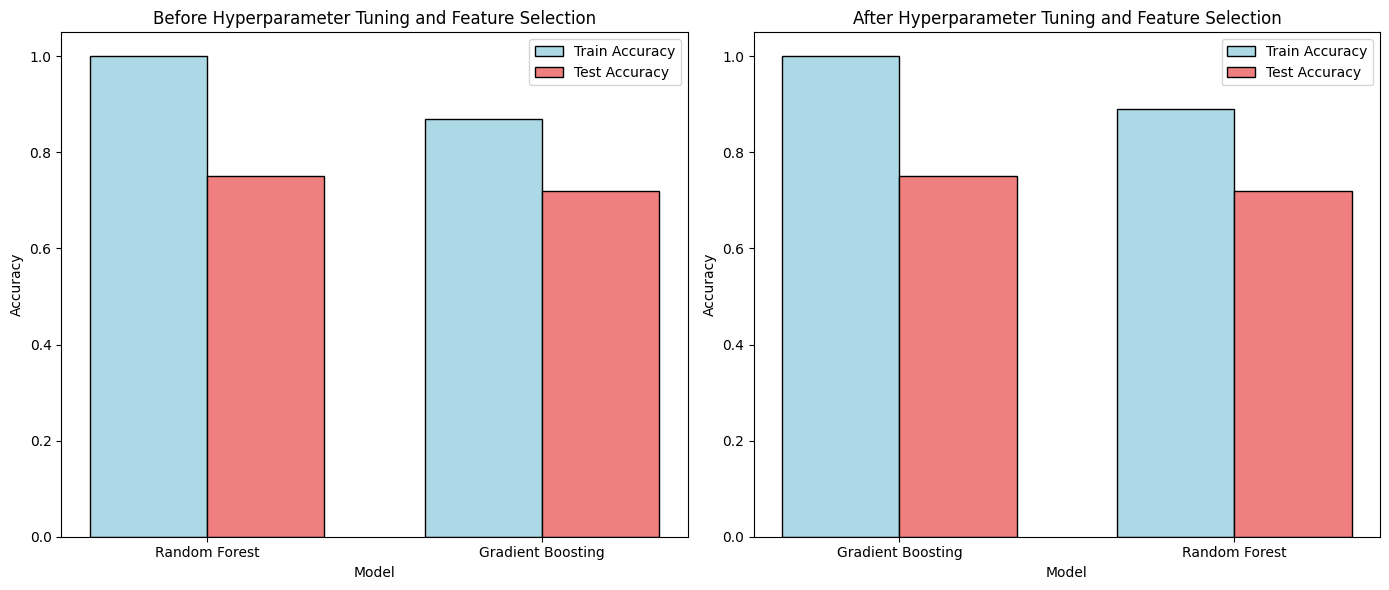

In [57]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
x = np.arange(len(final_models["Model"]))
width = 0.35

plt.bar(x - width/2, initial_models["Train Accuracy"], width, label="Train Accuracy", color='lightblue', edgecolor='black')
plt.bar(x + width/2, final_models["Test Accuracy"], width, label="Test Accuracy", color='lightcoral', edgecolor='black')

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Before Hyperparameter Tuning and Feature Selection")
plt.xticks(x, initial_models["Model"])
plt.legend()

plt.subplot(1, 2, 2)
x = np.arange(len(final_models["Model"]))

plt.bar(x - width/2, final_models["Train Accuracy"], width, label="Train Accuracy", color='lightblue', edgecolor='black')
plt.bar(x + width/2, final_models["Test Accuracy"], width, label="Test Accuracy", color='lightcoral', edgecolor='black')

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("After Hyperparameter Tuning and Feature Selection")
plt.xticks(x, final_models["Model"])
plt.legend()

plt.tight_layout()
plt.show()


### Model Performance Comparison

#### Initial Models (Without Hyperparameter Tuning and Feature Selection):

| Model              | Train Accuracy | Test Accuracy | Test F1 Score | Test Precision | Test Recall |
|--------------------|----------------|---------------|---------------|----------------|-------------|
| Random Forest      | 1.00           | 0.72          | 0.65          | 0.62           | 0.68        |
| Gradient Boosting  | 0.87           | 0.71          | 0.67          | 0.58           | 0.79        |

#### Final Models (With Hyperparameter Tuning and Feature Selection):

| Model              | Train Accuracy | Test Accuracy | Test F1 Score | Test Precision | Test Recall |
|--------------------|----------------|---------------|---------------|----------------|-------------|
| Gradient Boosting  | 1.00           | 0.75          | 0.70          | 0.64           | 0.76        |
| Random Forest      | 0.89           | 0.72          | 0.66          | 0.61           | 0.73        |

### Observations:

- **Test Accuracy:** Both models show almost the same test accuracy in both cases, with a slight improvement for Gradient Boosting (from 71% to 75%).
- **F1 Score:** 
  - Gradient Boosting shows an improvement in F1 score (from 67% to 70%).
  - Random Forest's F1 score improved slightly (from 65% to 66%).
- **Train Accuracy:** 
  - Random Forest experienced a significant drop in train accuracy (from 100% to 89%), which indicates better generalization after hyperparameter tuning and feature selection.
- **Precision and Recall:** 
  - For Gradient Boosting, precision improved from 58% to 64%, but recall slightly decreased from 79% to 76%.
  - Random Forest saw a slight decline in both precision and recall, possibly indicating a trade-off between these metrics in the final model.

### Conclusion:

- **Best Performing Model:** 
  - **Gradient Boosting** outperforms Random Forest overall, with higher test accuracy, F1 score, and precision improvements. The slight decrease in recall does not outweigh the other improvements.
  
- **Impact of Hyperparameter Tuning and Feature Selection:**
  - These techniques seem to have helped Gradient Boosting, improving its generalization and performance on the test set.
  - For Random Forest, the drop in training accuracy indicates reduced overfitting, leading to better generalization, though there was not much improvement in performance metrics.
  
Overall, hyperaparameter tuning and feature selection made **Random Forest** generalize better to the new data but still **Gradient Boosting** has overall higher score in all the metrics, so according to me, the Boosting performs better.


---

## Save the model

In [59]:
clf=GradientBoostingClassifier(**gb_params)
clf.fit(X_train_rf_selected, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=10, min_samples_leaf=4,
                           n_estimators=200)

In [ ]:
import joblib

joblib.dump(clf, '../models/gradient_boostings_model.pkl')

['../models/gradient_boosting_model.pkl']